In [47]:
from pathlib import Path
import torch
from gelos.gelosdatamodule import GELOSDataModule
import yaml
from gelos import config
from lightning.pytorch import Trainer
from pathlib import Path
from tqdm import tqdm
from gelos.config import PROJ_ROOT, EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR, DATA_VERSION, RAW_DATA_DIR, FIGURES_DIR
from terratorch.tasks import EmbeddingGenerationTask
from gelos.embedding_generation import LenientEmbeddingGenerationTask
from lightning.pytorch.cli import instantiate_class
import numpy as np
from matplotlib import transforms, patches
import matplotlib.pyplot as plt


In [2]:
yaml_file = "prithvieov2300_noperturb.yaml"

In [3]:
yaml_config_directory = PROJ_ROOT / 'gelos' / 'configs'
yaml_path = yaml_config_directory / yaml_file
print(yaml_path)

/app/gelos/configs/prithvieov2300_noperturb.yaml


## Run Embedding Generation step by step

In [48]:
with open(yaml_path, "r") as f:
        yaml_config = yaml.safe_load(f)

print(yaml.dump(yaml_config))

model_name = yaml_config['model']['init_args']['model']
output_dir = PROCESSED_DATA_DIR / DATA_VERSION / model_name
output_dir.mkdir(exist_ok=True, parents=True)
data_root = RAW_DATA_DIR / DATA_VERSION
figures_dir = FIGURES_DIR / DATA_VERSION
figures_dir.mkdir(exist_ok=True, parents=True)
# add variables to yaml config so it can be passed to classes
yaml_config['data']['init_args']['data_root'] = data_root
yaml_config['model']['init_args']['output_dir'] = output_dir

# instantiate transform classes if they exist
if "transform" in yaml_config["data"]["init_args"].keys():
      yaml_config["data"]["init_args"]["transform"] = [
            instantiate_class(args = (), init=class_path) for class_path in yaml_config["data"]["init_args"]["transform"]
      ]
gelos_datamodule = GELOSDataModule(**yaml_config['data']['init_args'])
task = LenientEmbeddingGenerationTask(**yaml_config['model']['init_args'])

device = 'gpu' if torch.cuda.is_available() else 'cpu'
trainer = Trainer(accelerator=device, devices=1)

data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 16
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:
      - BLUE
      - GREEN
      - RED
      - NIR

/opt/venv/lib/python3.11/site-packages/terratorch/tasks/embedding_generation.py:67: UserWarning: GeoTIFF selected; 2D token embeddings (ViT) will be reshaped to [C, sqrt(num_tokens), sqrt(num_tokens)] after dropping CLS if present.
  warnings.warn(
INFO:httpx:HTTP Request: HEAD https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M/resolve/main/Prithvi_EO_V2_300M.pt "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M/resolve/main/Prithvi_EO_V2_300M.pt "HTTP/1.1 302 Found"
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
INFO:root:L

### Inspect model and ensure weights have been loaded correctly

In [5]:
from models.prithvi_eo_v2 import PrithviViT

In [32]:
model_version = "300M"
prithvi_model = PrithviViT(num_frames = 4, in_chans = 6, model_size = model_version)
weights_path = EXTERNAL_DATA_DIR / "model_weights"/ f"Prithvi_EO_V2_{model_version}.pt"
state_dict = torch.load(weights_path)
encoder_state_dict = {}
for k, v in state_dict.items():
    if 'pos_embed' in k:
        continue
    if k.startswith('encoder'):
        new_key = k.replace("encoder.", "", 1)
        encoder_state_dict[new_key] = v

In [34]:
for k, v in task.model.named_parameters():
    weights = encoder_state_dict[k]
    print(k)
    print("mean weights from huggingface: ", weights.mean().item())
    print("mean weights from terratorch: ", v.mean().item())
    print("any equivalent: ", (weights == v).any().item())
    

cls_token
mean weights from huggingface:  0.000820714223664254
mean weights from terratorch:  0.000820714223664254
any equivalent:  True
patch_embed.proj.weight
mean weights from huggingface:  -0.00044657185208052397
mean weights from terratorch:  -0.00044657185208052397
any equivalent:  True
patch_embed.proj.bias
mean weights from huggingface:  -0.014625811949372292
mean weights from terratorch:  -0.014625811949372292
any equivalent:  True
blocks.0.norm1.weight
mean weights from huggingface:  0.397368848323822
mean weights from terratorch:  0.397368848323822
any equivalent:  True
blocks.0.norm1.bias
mean weights from huggingface:  -0.008639749139547348
mean weights from terratorch:  -0.008639749139547348
any equivalent:  True
blocks.0.attn.qkv.weight
mean weights from huggingface:  -1.5966246792231686e-05
mean weights from terratorch:  -1.5966246792231686e-05
any equivalent:  True
blocks.0.attn.qkv.bias
mean weights from huggingface:  -0.0024480826687067747
mean weights from terratorc

### Inspect outputs of dataset

In [49]:
gelos_datamodule.setup(stage="predict")

In [50]:
for k, v in gelos_datamodule.dataset[1].items():
    if k == "image" and isinstance(v, dict):
        for sensor, data in v.items():
            print(sensor, data.shape)
    elif k == "image":
        print (k, v.shape)
    else:
        print(k, v)

image torch.Size([6, 4, 96, 96])
filename 000001
file_id 1


[2, 1, 0]


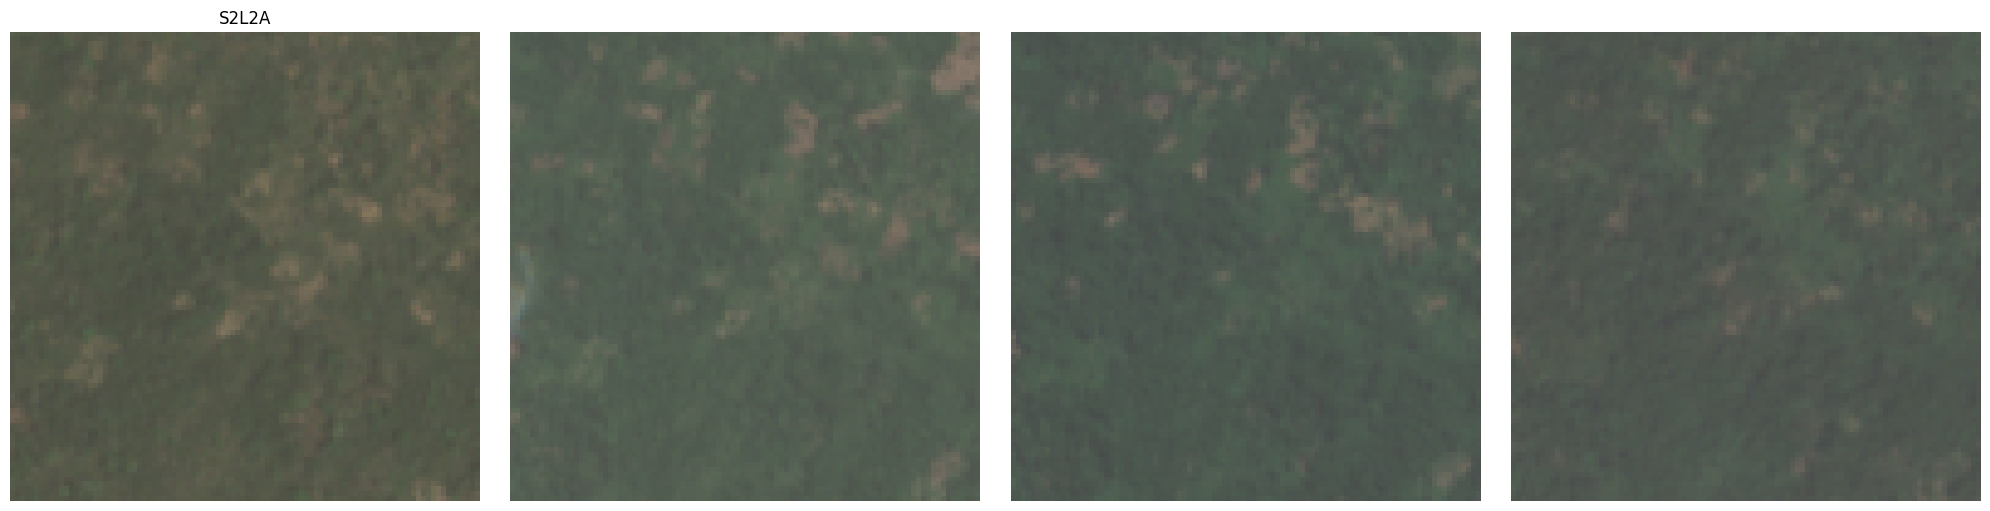

In [51]:
plot = gelos_datamodule.dataset.plot(gelos_datamodule.dataset[0])

## Generate Embeddings

### Generate one embedding and inspect

In [52]:
sample = gelos_datamodule.dataset[0] # get one sample from the dataset
image = sample["image"].unsqueeze(0) # add dummy batch dimension
final_layer_embedding = task.model(image)[-1]


In [53]:
has_cls = yaml_config['model']['init_args']['has_cls']

In [54]:
patch_tokens_flat = final_layer_embedding.reshape(-1, final_layer_embedding.shape[-1])
first_feature = patch_tokens_flat[:, 0].detach().cpu().numpy()


In [55]:
n_per_grid = 36
date_ranges = ["Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"]

CLS Token {'start': -1, 'stop': 0, 'step': 1}
All Steps of Middle Patch {'start': 15, 'stop': 143, 'step': 36}
All Patches from April to June {'start': 36, 'stop': 72, 'step': 1, 'outline_plot': 1}


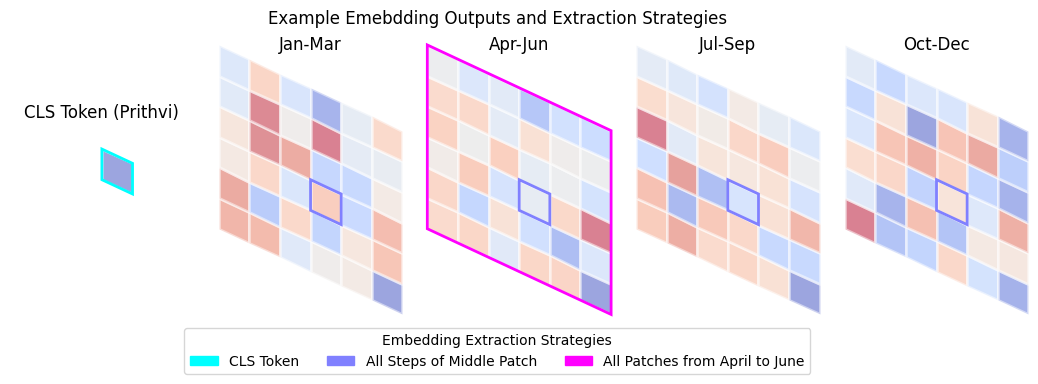

In [ ]:

grid_side = int(np.ceil(np.sqrt(n_per_grid)))
cells_per_grid = grid_side * grid_side
start_index = 1 if has_cls else 0
groups = [first_feature[i : i + n_per_grid] for i in range(start_index, first_feature.shape[0], n_per_grid)]
group_count = len(groups)
cols = group_count + 1
rows = 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
axes_flat = axes.ravel() if isinstance(axes, np.ndarray) else np.array([axes])
mesh = None
x_skew = 0
y_skew = -25
skew_base = transforms.Affine2D().skew_deg(x_skew, y_skew)

n_per_grid = 36 # adjust grouping size if needed
highlight_dict = {}
cls_first_patch_highlights = []
# only works with prithvi configs, since this is capable of showing all extraction strategies including CLS
for extraction_strategy, slice_args in yaml_config['embedding_extraction_strategies'].items():
    highlight_spec = slice_args[0].copy()
    if highlight_spec["stop"] is None:
        highlight_spec["stop"] = n_per_grid * group_count
    if has_cls:
        highlight_spec["start"] -= start_index 
        highlight_spec["stop"] -= start_index
    if highlight_spec["stop"] - highlight_spec["start"] == n_per_grid and highlight_spec["step"] == 1:
        highlight_spec["outline_plot"] = int(round((highlight_spec["stop"] - highlight_spec["start"]) / n_per_grid))
    highlight_dict[extraction_strategy] = highlight_spec
    if highlight_spec["start"] < 0:
        cls_first_patch_highlights.append(extraction_strategy)
    print(extraction_strategy, highlight_spec)
cmap = plt.get_cmap("cool", max(len(highlight_dict), 1))
for idx, (name, spec) in enumerate(highlight_dict.items()):
    spec["color"] = cmap(idx)

outline_map = {}
highlight_map = {}
for name, spec in highlight_dict.items():
    outline_idx = spec.get("outline_plot")
    if outline_idx is not None and 0 <= outline_idx < group_count:
        outline_map.setdefault(outline_idx, []).append(spec["color"])
        continue
    if spec.get("start", 0) < 0:
        continue
    abs_start = max(0, spec.get("start", 0))
    abs_stop = min(spec.get("stop", first_feature.shape[0]), first_feature.shape[0])
    abs_step = max(1, spec.get("step", 1))
    for token_idx in range(abs_start, abs_stop, abs_step):
        group_idx = token_idx // n_per_grid
        if group_idx >= group_count:
            break
        highlight_map.setdefault(group_idx, []).append((token_idx % n_per_grid, spec["color"], name))

legend_patches = [patches.Patch(color=spec["color"], label=name) for name, spec in highlight_dict.items()]

# first patch (single square) on the left, sized like a normal patch cell and centered
first_patch_value = first_feature[start_index]
single_patch_grid = np.full((grid_side, grid_side), np.nan)
center_idx = grid_side // 2
single_patch_grid[center_idx, center_idx] = first_patch_value
ax_first = axes_flat[0]
mesh = ax_first.pcolormesh(single_patch_grid, cmap='coolwarm', edgecolors='white', linewidth=2, shading='auto', alpha=0.5,
                         transform=skew_base + ax_first.transData, antialiased=True)
mesh.set_clip_on(False)
for cls_name in cls_first_patch_highlights:
    color = highlight_dict[cls_name]["color"]
    rect = patches.Rectangle((center_idx, center_idx), 1, 1, fill=False, edgecolor=color, linewidth=2,
                             transform=skew_base + ax_first.transData, clip_on=False)
    ax_first.add_patch(rect)
ax_first.set_title('CLS Token (Prithvi)', y=.7)
ax_first.set_xticks([])
ax_first.set_yticks([])
ax_first.set_aspect('equal')
for spine in ax_first.spines.values():
    spine.set_visible(False)

for idx, group_values in enumerate(groups):
    chunk = group_values.copy()
    chunk.shape
    if chunk.shape[0] < n_per_grid:
        chunk = np.concatenate([chunk, np.full(n_per_grid - chunk.shape[0], np.nan, dtype=chunk.dtype)])
    if chunk.shape[0] < cells_per_grid:
        chunk = np.concatenate([chunk, np.full(cells_per_grid - chunk.shape[0], np.nan, dtype=chunk.dtype)])
    grid = chunk.reshape(grid_side, grid_side)
    ax = axes_flat[idx + 1]
    mesh = ax.pcolormesh(grid, cmap='coolwarm', edgecolors='white', linewidth=2, shading='auto', alpha=0.5,
                         transform=skew_base + ax.transData, antialiased=True)
    mesh.set_clip_on(False)
    for cell_idx, color, _name in highlight_map.get(idx, []):
        row = cell_idx // grid_side
        col = cell_idx % grid_side
        rect = patches.Rectangle((col, row), 1, 1, fill=False, edgecolor=color, linewidth=2,
                                 transform=skew_base + ax.transData, clip_on=False)
        ax.add_patch(rect)
    for outline_color in outline_map.get(idx, []):
        outline = patches.Rectangle((0, 0), grid_side, grid_side, fill=False, edgecolor=outline_color, linewidth=2,
                                    transform=skew_base + ax.transData, clip_on=False)
        ax.add_patch(outline)
    ax.set_title(f'{date_ranges[idx]}', y=0.95)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)

for ax in axes_flat[group_count + 1:]:
    ax.axis('off')

fig.subplots_adjust(wspace=-0.60, hspace=-0.60)
if legend_patches:
    fig.legend(
        handles=legend_patches,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.08),
        ncol=max(len(legend_patches), 1),
        title="Embedding Extraction Strategies"
    )
plt.suptitle("Example Emebdding Outputs and Extraction Strategies")
# plt.savefig(figures_dir / "example_embedding_outputs.png")

### Generate all embeddings

In [14]:
# Generate Embeddings
trainer.predict(model=task, datamodule=gelos_datamodule)
print("marking embeddings as complete")

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined